In [3]:
from netCDF4 import Dataset, date2num
from scipy.stats import linregress
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Data Preprocessing

##### Computing daily mean from hourly data and merging

In [1]:
## Case of specific humidity and horizontal components of wind
# Computing daily mean
input_folder="../input_data" # update with correct path
output_folder="../input_data" # update with correct path
files=os.listdir(input_folder)
for file in files:
    input_file=os.path.join(input_folder, file)
    ds=xr.open_dataset(input_file)
    print(f'Processing with the file {input_file}')
    daily_ds = ds.resample(valid_time='1D').mean()
    output_file=input_file.replace(".nc", "_daily_mean.nc")
    output_path=os.path.join(output_folder, output_file)
    daily_ds.to_netcdf(output_path)
    print(f'Finished with the file {file} and saved')
    
# Merging data
input_folder="../input_data" # update with correct path
output_folder="../input_data" # update with correct path
output_file ="merged_quv_output.nc"  # update with correct filename
output_path = os.path.join(output_folder, output_file)
files_to_merge=os.listdir(input_folder)
files_merged=[os.path.join(input_folder, f) for f in files_to_merge]
files_to_merge_test=sorted(files_merged)
datasets = [xr.open_dataset(file) for file in files_to_merge_test]
combined_dataset = xr.concat(datasets, dim='valid_time')
combined_dataset.to_netcdf(output_path)
print(f"Merged file saved as {output_file}")

##### Rewriting data to be able to compute Vertical Integrate Moisture Flux

In [11]:
start_date = "1984-12-01"
end_date = "2023-12-31"
dates = pd.date_range(start=start_date, end=end_date, freq="D")
dates = dates[dates.month.isin([12])]

In [13]:
## Case of specific humidity and horizontal components of wind
data=xr.open_dataset('../input_data/merged_quv_output.nc')
data=data.where(data.valid_time.dt.month.isin([12]), drop=True)
q_data=data.q.values
u_data=data.u.values
v_data=data.v.values
lat_data=data.latitude.values
lon_data=data.longitude.values
#time_data=data.valid_time.values
lev_data=data.pressure_level.values

output_file = "../input_data/merged_quv_output_ok5.nc"

with Dataset(output_file, "w", format="NETCDF4") as nc_file:
    # Create dimensions
    nc_file.createDimension("time", len(dates)) 
    nc_file.createDimension("lev", len(lev_data))
    nc_file.createDimension("lat", len(lat_data))
    nc_file.createDimension("lon", len(lon_data))

    # Create coordinate variables
    times = nc_file.createVariable("time", "f8", ("time",))
    lev = nc_file.createVariable("lev", "f8", ("lev",))
    lat = nc_file.createVariable("lat", "f8", ("lat",))
    lon = nc_file.createVariable("lon", "f8", ("lon",))

    # Create variables
    q = nc_file.createVariable("q", "f8", ("time", "lev", "lat", "lon",))
    u = nc_file.createVariable("u", "f8", ("time", "lev", "lat", "lon",))
    v = nc_file.createVariable("v", "f8", ("time", "lev", "lat", "lon",))

    # Add attributes to coordinate variables
    times.units = "hours since 1984-01-01 00:00:00"
    times.calendar = "gregorian"
    lev.units = "hPa"
    lev.long_name = "Pressure level"
    lat.units = "degrees_north"
    lon.units = "degrees_east"
    lat.long_name = "Latitude"
    lon.long_name = "Longitude"
    
    # Add attributes to data variables
    u.units = "m/s"
    u.long_name = "Zonal wind component"
    v.units = "m/s"
    v.long_name = "Meridional wind component"
    q.units = "kg/kg"
    q.long_name = "Specific humidity"

    # Write data to coordinate variables
    times[:] = date2num(dates.to_pydatetime(), units=times.units, calendar=times.calendar)
    lev[:] = lev_data
    lat[:] = lat_data
    lon[:] = lon_data

    # Write data to data variables
    u[:, :, :, :] = u_data
    v[:, :, :, :] = v_data
    q[:, :, :, :] = q_data

print(f"NetCDF file '{output_file}' created successfully.")

NetCDF file '/users/fs1/flmouassom/Project2/data_used/merged_quv_output_ok5.nc' created successfully.


##### Extreme day selection

In [6]:
data=xr.open_dataset('../input_data/CA_1984-2023_daily_pr_masked.nc')
dat=data['pr'].values
dat_anom=(dat-dat.mean(axis=0))/dat.std(axis=0)
day=pd.DataFrame({'time':[0], 'nwet':[0], 'ndry':[0], 'nreg':[0]})
n_total=12233
for k in range(dat_anom.shape[0]):
    nwet=0
    ndry=0
    nreg=0
    for i in range(dat_anom.shape[1]):
        for j in range(dat_anom.shape[2]):
            if dat_anom[k, i, j]>=2:
                nwet+=1
            if dat_anom[k, i, j]<=-2:
                ndry+=1
            if -2<dat_anom[k, i, j]<2:
                nreg+=1
    df1=pd.DataFrame({'time':[data.time[k].values], 'nwet':[(nwet*100)/n_total], 'ndry':[(ndry*100)/n_total], 'nreg':[(nreg*100)/n_total]})
    day=pd.concat([day, df1])
day = day[day['time'] != 0]
day['label'] = (day['nwet'] >= 10).astype(int)
day.reset_index(drop=True, inplace=True)
day.to_csv('../processed_data/extreme_event_days.csv', sep=',')

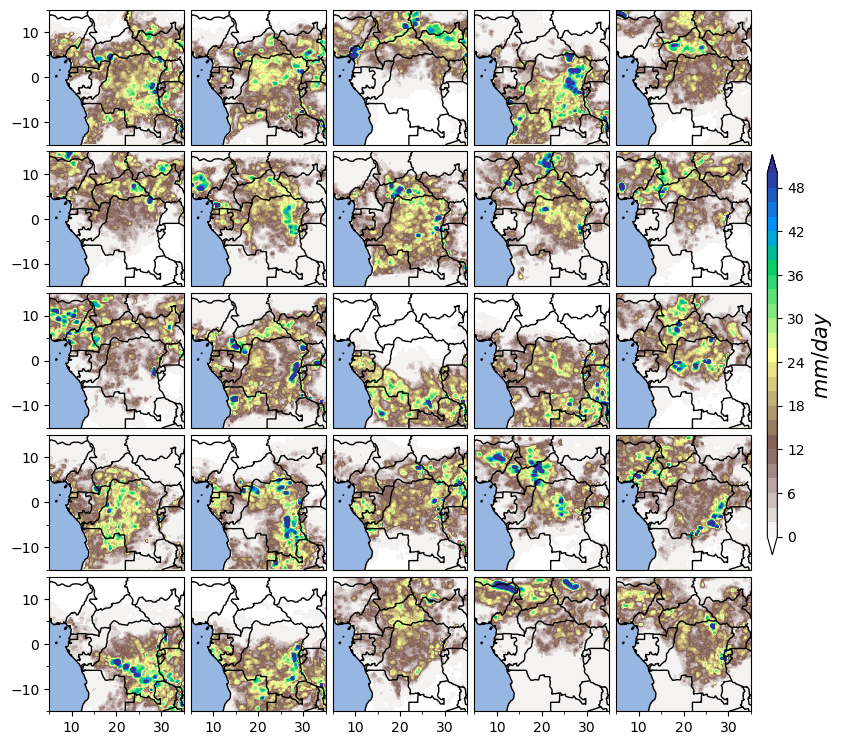

In [7]:
projection = ccrs.PlateCarree()
level=np.arange(0, 50.2, 2)
cmap='terrain_r'
fig = plt.figure(figsize=(10, 8))
df=pd.read_csv('../processed_data/extreme_event_days.csv')
df_reg=df[df['label']==1]
df_region=df_reg.sort_values(by='nwet', ascending=False)
df_region=np.array(pd.to_datetime(df_region['time']))
for k in range(25):
    ax = fig.add_subplot(5, 5, k+1, projection=projection)
    data_ex=data.where(data.time.isin([df_region[k]]), drop=True)
    mymap = ax.contourf(data.longitude, data.latitude, data_ex.pr[0, :, :], extend='both', cmap=cmap, levels=level)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    ax.add_feature(cfeature.LAND.with_scale('50m'))
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    if k in [0, 5, 10, 15, 20]:
        ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
    if k in [20, 21, 22, 23, 24]:
        ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
plt.tight_layout(h_pad=+0.5, w_pad=-15, rect=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([0.88, 0.3, 0.01, 0.5])
cbar = plt.colorbar(mymap, orientation='vertical', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r'$mm/day$', rotation=90, fontsize=15, fontweight='bold')
plt.savefig('../Figure/Figure.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 